In [1]:
# Step 1: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error


In [2]:
# Step 2: Load dataset
df = pd.read_csv("imdb_india.csv", encoding='latin1')

# Step 3: Drop rows with missing target
df = df.dropna(subset=['Rating'])
df.isnull().sum()

Name           0
Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

In [3]:
# Step 4: Clean numeric columns
df['Year'] = df['Year'].str.replace('(', '').str.strip()
df['Year'] = df['Year'].str.replace(')', '').str.strip()
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Duration'] = df['Duration'].str.replace('min', '').str.strip()
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Votes'] = df['Votes'].str.replace(',', '')
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')


In [4]:
# Step 5: Fill missing numeric values with column mean
df['Year'] = df['Year'].fillna(df['Year'].mean())
df['Duration'] = df['Duration'].fillna(df['Duration'].mean())
df['Votes'] = df['Votes'].fillna(df['Votes'].mean())

In [5]:
# Step 6: Safely handle Genre column
if 'Genre' in df.columns:
    df['Genre'] = df['Genre'].apply(lambda x: x if isinstance(x, str) else '')
    df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if x != '' else [])
    
    mlb = MultiLabelBinarizer()
    genre_encoded = pd.DataFrame(mlb.fit_transform(df['Genre']), columns=mlb.classes_)
    genre_encoded.index = df.index  # align indexes
    df = pd.concat([df, genre_encoded], axis=1)
    df.drop('Genre', axis=1, inplace=True)

In [6]:

# Step 7: Target encoding for Director and Actor 1
df['Director'] = df.groupby('Director')['Rating'].transform('mean')
df['Actor 1'] = df.groupby('Actor 1')['Rating'].transform('mean')

# Step 8: Fill any remaining missing values in Director and Actor 1
avg_rating = df['Rating'].mean()
df['Director'] = df['Director'].fillna(avg_rating)
df['Actor 1'] = df['Actor 1'].fillna(avg_rating)

In [7]:
# Step 9: Define features and target
X = df.drop(['Name', 'Rating', 'Actor 2', 'Actor 3'], axis=1)
y = df['Rating']

In [8]:
X.isnull().sum()

Year           0
Duration       0
Votes          0
Director       0
Actor 1        0
Action         0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
News           0
Romance        0
Sci-Fi         0
Sport          0
Thriller       0
War            0
Western        0
dtype: int64

In [9]:
# Step 10: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Step 11: Train model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Step 12: Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.4983603446969696


In [15]:
#Step 12: Predict movie rating for custom input

# Function to prepare user input
def predict_custom_rating(year, duration, votes, director_name, actor1_name, genres_list):
    # Create an empty input row with all columns in X
    input_data = pd.DataFrame([0] * len(X.columns), index=X.columns).T    
    # Set numeric values
    input_data['Year'] = year
    input_data['Duration'] = duration
    input_data['Votes'] = votes    
    # Encode Director and Actor 1 using target mean (or global avg if not found)
    input_data['Director'] = df[df['Director'].notnull()].set_index('Director')['Rating'].get(director_name, avg_rating)
    input_data['Actor 1'] = df[df['Actor 1'].notnull()].set_index('Actor 1')['Rating'].get(actor1_name, avg_rating)   
    # Set genre values
    for genre in genres_list:
        if genre in input_data.columns:
            input_data[genre] = 1  # mark genre as active
    # Predict
    prediction = model.predict(input_data)[0]
    return round(prediction, 2)

In [20]:
# Example 1: Drama, Comedy movie by known director & actor
predicted_rating = predict_custom_rating(
    year=2009,
    duration=170,
    votes=50000,
    director_name='Rajkumar Hirani',
    actor1_name='Shah Rukh Khan',
    genres_list=['Drama', 'Comedy']
)
print("Predicted Rating:", predicted_rating)

Predicted Rating: 7.23


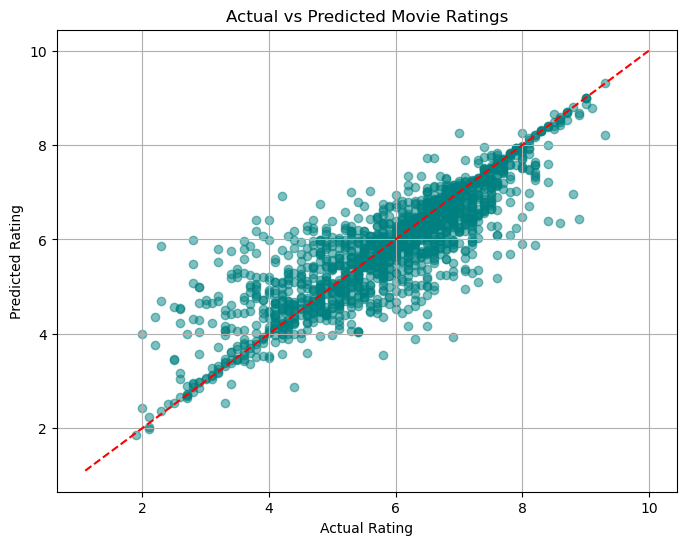

In [23]:
import matplotlib.pyplot as plt
# Predict ratings on the test set
y_pred = model.predict(X_test)
# Plot Actual vs Predicted Ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Movie Ratings')
plt.grid(True)
plt.show()

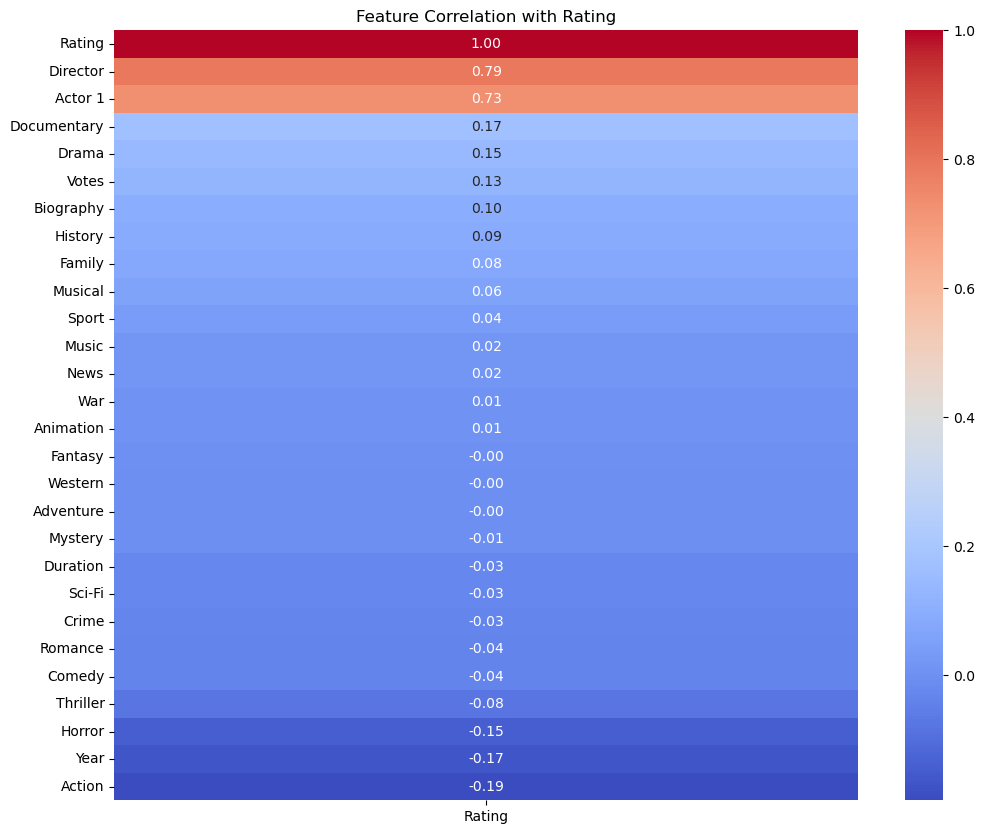

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X and y to compute correlations
df_corr = X.copy()
df_corr['Rating'] = y  # add target back for correlation

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['Rating']].sort_values(by='Rating', ascending=False), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation with Rating')
plt.show()